In [ ]:
# !pip install git+https://github.com/dpkp/kafka-python.git
# !pip install pandas

# Q1

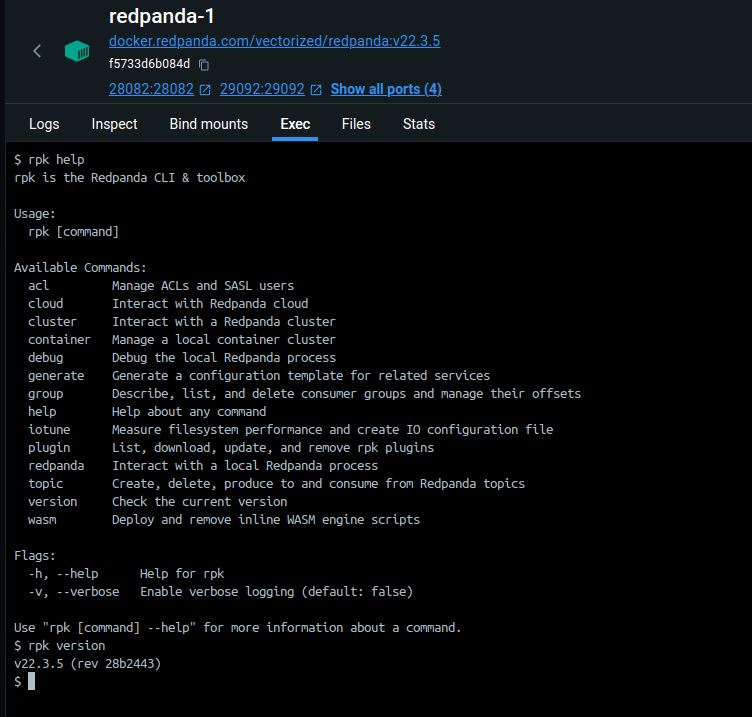

v22.3.5 (rev 28b2443)

# Q2

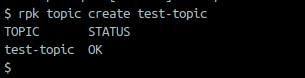

# Q3

In [1]:
import json
import time 

from kafka import KafkaProducer

def json_serializer(data):
    return json.dumps(data).encode('utf-8')

server = 'localhost:9092'

producer = KafkaProducer(
    bootstrap_servers=[server],
    value_serializer=json_serializer
)

producer.bootstrap_connected()

True

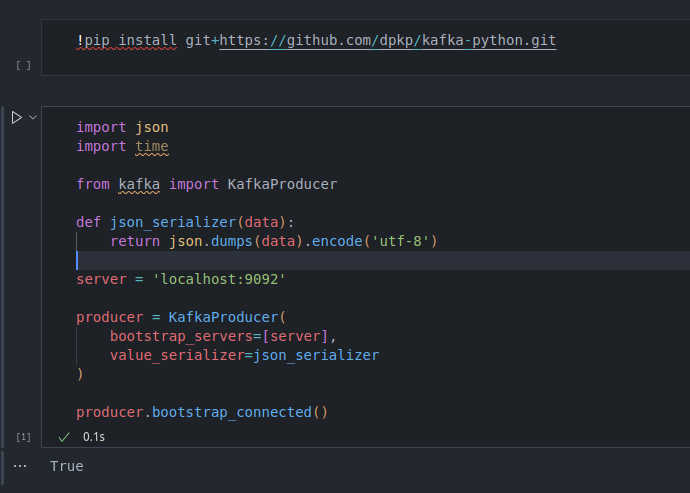

In [2]:
t0 = time.time()

topic_name = 'test-topic'

for i in range(10):
    message = {'number': i}
    producer.send(topic_name, value=message)
    print(f"Sent: {message}")
    time.sleep(0.05)

producer.flush()

t1 = time.time()
print(f'took {(t1 - t0):.2f} seconds')

Sent: {'number': 0}
Sent: {'number': 1}
Sent: {'number': 2}
Sent: {'number': 3}
Sent: {'number': 4}
Sent: {'number': 5}
Sent: {'number': 6}
Sent: {'number': 7}
Sent: {'number': 8}
Sent: {'number': 9}
took 0.51 seconds


# Q5

In [8]:
import pandas as pd
import time
from kafka import KafkaProducer
import gzip
import json

In [9]:
# Read the green csv.gz file
green_file_path = 'green_tripdata_2019-10.csv.gz'  # Replace 'path_to_green_csv.gz' with the actual file path
with gzip.open(green_file_path, 'rt') as file:
    df_green = pd.read_csv(file)

# Select only the required columns
df_green = df_green[['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'tip_amount']]

# Kafka Setup
bootstrap_servers = 'localhost:9092'  # Update with actual Kafka server address
topic = 'green-trips'
producer = KafkaProducer(bootstrap_servers=bootstrap_servers)

# Iterate over the records in the dataframe
start_time = time.time()
for row in df_green.itertuples(index=False):
    row_dict = {col: getattr(row, col) for col in row._fields}
    # Sending the data to Kafka
    producer.send(topic, value=json.dumps(row_dict).encode('utf-8'))
    # print(row_dict)  # Uncomment to print the dictionary if needed
producer.flush()
producer.close()
end_time = time.time()

# Calculate time taken in seconds
time_taken = round(end_time - start_time)
print("Time taken (seconds):", time_taken)


/tmp/ipykernel_46064/4049773096.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_green = pd.read_csv(file)


Time taken (seconds): 40


# Creating the PySpark consumer

In [10]:
import pyspark
from pyspark.sql import SparkSession

pyspark_version = pyspark.__version__
kafka_jar_package = f"org.apache.spark:spark-sql-kafka-0-10_2.12:{pyspark_version}"

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("GreenTripsConsumer") \
    .config("spark.jars.packages", kafka_jar_package) \
    .getOrCreate()

24/04/04 13:35:50 WARN Utils: Your hostname, kasl resolves to a loopback address: 127.0.1.1; using 192.168.64.212 instead (on interface enxaa7eb6daa676)
24/04/04 13:35:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/al/apps/spark-3.5.0-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/al/.ivy2/cache
The jars for the packages stored in: /home/al/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0291acdc-2f84-4467-9666-4128d805d663;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.0 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
downloading https://repo1.maven.org/maven2/org/apache/spark/spark-sql-

In [11]:
green_stream = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "green-trips") \
    .option("startingOffsets", "earliest") \
    .load()

In [12]:
def peek(mini_batch, batch_id):
    first_row = mini_batch.take(1)

    if first_row:
        print(first_row[0])

query = green_stream.writeStream.foreachBatch(peek).start()

24/04/04 13:37:33 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-e96b2cde-701c-4b19-8c59-1df17918080e. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/04/04 13:37:33 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


24/04/04 13:37:34 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Row(key=None, value=bytearray(b'{"lpep_pickup_datetime": "2019-10-01 00:26:02", "lpep_dropoff_datetime": "2019-10-01 00:39:58", "PULocationID": 112, "DOLocationID": 196, "passenger_count": 1.0, "trip_distance": 5.88, "tip_amount": 0.0}'), topic='green-trips', partition=0, offset=0, timestamp=datetime.datetime(2024, 4, 4, 13, 33, 24, 823000), timestampType=0)


In [13]:
query.stop()

# Q6

In [14]:
from pyspark.sql import types

schema = types.StructType() \
    .add("lpep_pickup_datetime", types.StringType()) \
    .add("lpep_dropoff_datetime", types.StringType()) \
    .add("PULocationID", types.IntegerType()) \
    .add("DOLocationID", types.IntegerType()) \
    .add("passenger_count", types.DoubleType()) \
    .add("trip_distance", types.DoubleType()) \
    .add("tip_amount", types.DoubleType())

In [15]:
from pyspark.sql import functions as F

green_stream = green_stream \
  .select(F.from_json(F.col("value").cast('STRING'), schema).alias("data")) \
  .select("data.*")

In [16]:
green_stream

DataFrame[lpep_pickup_datetime: string, lpep_dropoff_datetime: string, PULocationID: int, DOLocationID: int, passenger_count: double, trip_distance: double, tip_amount: double]

# Q7

In [18]:
from pyspark.sql.functions import current_timestamp, window, col

# Add a column "timestamp" using the current_timestamp function
df = green_stream.withColumn("timestamp", current_timestamp())

# Group by 5 minutes window based on the timestamp column and DOLocationID
popular_destinations = df \
    .groupBy(window("timestamp", "5 minutes"), "DOLocationID") \
    .count() \
    .orderBy(col("count").desc())

# Start the streaming query to write the output to the console
query = popular_destinations \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", "false") \
    .start()

# Wait for the termination of the query
query.awaitTermination()

24/04/04 13:43:53 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-feb2e6cf-0dde-4a7e-80be-f244054ec25f. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/04/04 13:43:53 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
24/04/04 13:43:53 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------------------------+------------+-----+
|window                                    |DOLocationID|count|
+------------------------------------------+------------+-----+
|{2024-04-04 13:40:00, 2024-04-04 13:45:00}|74          |17741|
|{2024-04-04 13:40:00, 2024-04-04 13:45:00}|42          |15942|
|{2024-04-04 13:40:00, 2024-04-04 13:45:00}|41          |14061|
|{2024-04-04 13:40:00, 2024-04-04 13:45:00}|75          |12840|
|{2024-04-04 13:40:00, 2024-04-04 13:45:00}|129         |11930|
|{2024-04-04 13:40:00, 2024-04-04 13:45:00}|7           |11533|
|{2024-04-04 13:40:00, 2024-04-04 13:45:00}|166         |10845|
|{2024-04-04 13:40:00, 2024-04-04 13:45:00}|236         |7913 |
|{2024-04-04 13:40:00, 2024-04-04 13:45:00}|223         |7542 |
|{2024-04-04 13:40:00, 2024-04-04 13:45:00}|238         |7318 |
|{2024-04-04 13:40:00, 2024-04-04 13:45:00}|82          |7292 |
|{2024-

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/al/apps/spark-3.5.0-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/al/apps/spark-3.5.0-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/al/miniconda3/lib/python3.12/socket.py", line 707, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [19]:
query.stop()